In [1]:
# Imports
import math
import numpy as np
import torch
from matplotlib import pyplot as plt, patches
plt.rcParams['savefig.dpi'] = 300

In [2]:
# Variables

m = 85000
c = 6
aL = 30
aD = 2
Tmin = 40000
Tmax = 80000
omin = -22.5 * (math.pi / 180)
omax = 22.5 * (math.pi / 180)
Vmin = 180
Vmax = 240
ymin = -22.5 * (math.pi / 180)
ymax = 22.5 * (math.pi / 180)
g = 9.8 # gravity

T = 2.5
dt = 0.001
N = 1024
lam = 60

In [3]:
# Flight dynamics

def Vt(V_, y_, u1_):
    Vt = - aD * V_ ** 2 / m - g * math.sin(y_) + 1 / m * u1_
    return Vt

def yt(V_, y_, u2_):
    yt = aL * y_ * (1 - c * V_) / m - g * math.cos(y_) / V_ + aL * c * V_ / m * u2_
    return yt

In [4]:
# Optimal controls
# move here

In [5]:
# Simulation loop

def flight_sim(T, dt, init):

    N_ = init[0].size()[0]

    ts = torch.arange(0, T, dt)
    Vs = torch.zeros((N_, ts.size()[0]))
    ys = torch.zeros((N_, ts.size()[0]))

    Vs[:,0] = init[0]
    ys[:,0] = init[1]

    for i in range(N_):

        for j in range(1, int(T / dt)):

            # u1 controls
            if Vs[i][j - 1] < (Vmin + Vmax) / 2:
                u1 = Tmax
            else:
                u1 = Tmin

            # u2 controls
            if ys[i][j - 1] < (ymin + ymax) / 2:
                u2 = omax
            else:
                u2 = omin

            if j == 1:
                u1 = 0; u2 = 0

            Vs[i][j] = Vs[i][j - 1] + Vt(Vs[i][j - 1], ys[i][j - 1], u1) * dt
            ys[i][j] = ys[i][j - 1] + yt(Vs[i][j - 1], ys[i][j - 1], u2) * dt

    Vs = torch.unsqueeze(Vs, 1)
    ys = torch.unsqueeze(ys, 1)
    xs = torch.cat((Vs, ys), 1)

    return xs, ts

In [6]:
# Uniform sampling simulations

Vs_init = torch.rand(N) * (Vmax - Vmin) + Vmin
ys_init = torch.rand(N) * (ymax - ymin) + ymin
xu_init = (Vs_init, ys_init)

xu, tu = flight_sim(T, dt, xu_init)
torch.save(xu, "../Data/x_uniform.pt")
torch.save(tu, "../Data/t_uniform.pt")

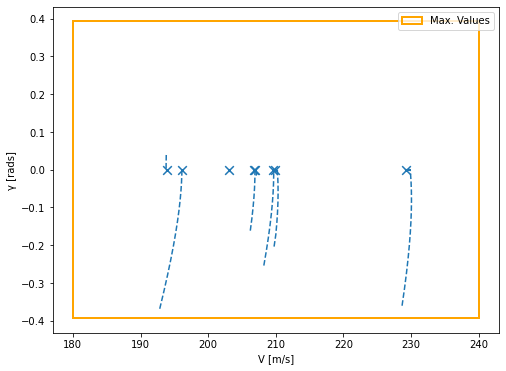

In [16]:
# Example paths

fig = plt.figure(figsize = (8, 6))
ax = plt.axes()

box = ax.add_patch(patches.Rectangle((Vmin, ymin), Vmax - Vmin, ymax - ymin, edgecolor='orange',
   facecolor='none', linewidth=2, zorder=1))

box.set_label("Max. Values")

Vs = xu[:,0]
ys = xu[:,1]

for i in range(8):
   ax.plot(Vs[i], ys[i], linestyle='--', c = "#1f77b4", zorder=2)
   ax.scatter(Vs[i, -1], ys[i, -1], marker = 'x', s=75, c = "#1f77b4", zorder=2)

ax.set(xlabel="V [m/s]", ylabel="\u03B3 [rads]")
ax.legend()

plt.savefig('../Figures/example_paths.png')
plt.show()

In [17]:
# loss function

adj = (ymax - ymin) / (Vmax - Vmin) # scaling factor

def l(x):
    x = torch.unsqueeze(x, -1)
    diff = torch.cat((adj*(x[0] - Vmin), x[1] - ymin, adj*(Vmax - x[0]), ymax - x[1]), -1)
    loss = torch.min(diff, -1).values
    return loss

In [18]:
# ROI sampling

def D():
    alt = 1.3
    V = (alt * (2 * torch.rand(1) - 1) * (Vmax - Vmin) + Vmin + Vmax) / 2
    y = (alt * (2 * torch.rand(1) - 1) * (ymax - ymin) + ymin + ymax) / 2
    return torch.tensor([V, y])

xr_init = torch.zeros((2, N))

i = 0
while i < N:
    a = D()
    b = np.random.rand() * lam
    if b <= lam * math.exp(- lam * abs(l(a))):
        xr_init[:,i] = a
        i += 1

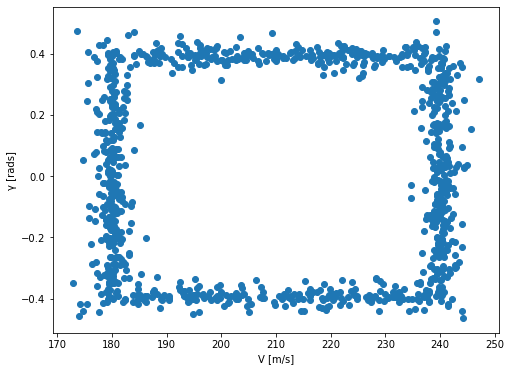

In [19]:
# Plotting initial conditions

fig = plt.figure(figsize = (8, 6))
ax = plt.axes()

plt.scatter(xr_init[0,:], xr_init[1,:])

ax.set(xlabel="V [m/s]", ylabel="\u03B3 [rads]")

plt.savefig('../Figures/sample_points.png')
plt.show()

In [20]:
# ROI sampling simulations

xr, tr = flight_sim(T, dt, xr_init)
torch.save(xr, "../Data/x_roi.pt")
torch.save(tr, "../Data/t_roi.pt")

In [21]:
# Data collocation

def collocate(xs, t):

    N_ = N # fix this
    ix = torch.floor(t.size()[0] * torch.rand(N_)).unsqueeze(-1).repeat_interleave(2, 1).unsqueeze(-1) # make adaptable
    ix = torch.tensor(ix, dtype=torch.int64)

    xi = torch.gather(xs, -1, ix).squeeze()
    ti = t[ix[:,0,0]]
    
    return xi, ti # combine these?

# Uniform sampling

xi_u, ti_u = collocate(xu, tu)

torch.save(xi_u, "../Data/xi_uniform.pt")
torch.save(ti_u, "../Data/ti_uniform.pt")

# ROI sampling

xi_roi, ti_roi = collocate(xr, tr)

torch.save(xi_roi, "../Data/xi_roi.pt")
torch.save(ti_roi, "../Data/ti_roi.pt")

<ipython-input-21-2418c585d256>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ix = torch.tensor(ix, dtype=torch.int64)


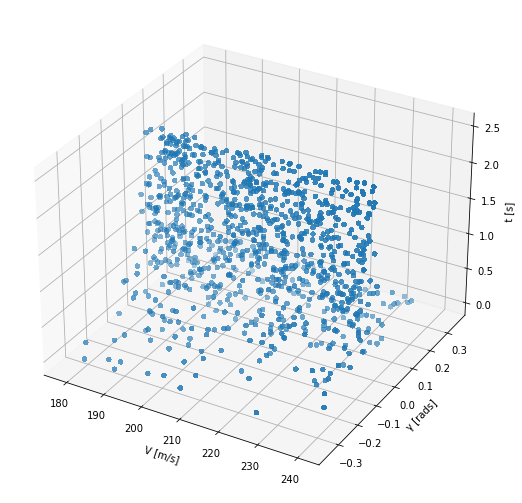

In [29]:
# Visualize collocated data

# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.scatter(xi_u[:,0], xi_u[:,1], ti_u, linewidth=0, antialiased=False)
ax.set(xlabel="V [m/s]", ylabel="\u03B3 [rads]", zlabel="t [s]")

plt.savefig('../Figures/collocated_uniform.png')
plt.show()

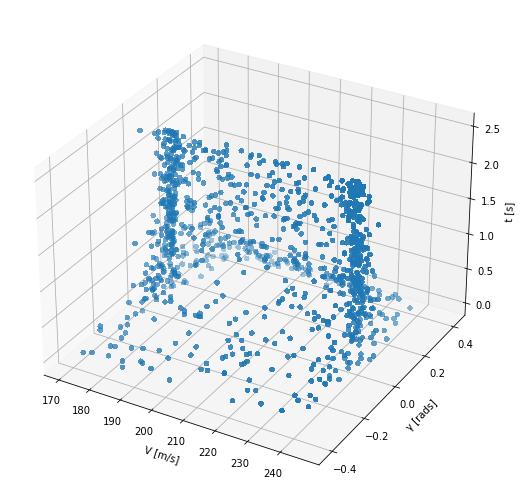

In [30]:
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.scatter(xi_roi[:,0], xi_roi[:,1], ti_roi, linewidth=0, antialiased=False)
ax.set(xlabel="V [m/s]", ylabel="\u03B3 [rads]", zlabel="t [s]")

plt.savefig('../Figures/collocated_roi.png')
plt.show()